In [3]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [28]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL

#Define key parameters
batch_size = 50
image_height = 256
image_width = 256
channels = 1 # images are in grayscale
epochs = 30
latent_dims = 128
depth = 32


def create_image(data):
    #Creates a 3D image with extra grayscale channel added
    #4D tensor now
    image = tf.io.decode_png(data, channels=1)
    #normalise the image - float values between 0 and 1
    image = image / 255
    #resize image to 256 x 256
    return tf.image.resize(image, [image_height, image_width], antialias = True)

def get_image_from_file(path):
    #Extract file contents
    raw_data = tf.io.read_file(path)
    image = create_image(raw_data)
    return image

def set_dataset_parameters(dataset):
    # Make sure the dataset is in batches, well-shuffled and prefetches the information
    dataset = dataset.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def create_train_test_dataset(path_to_training_folder, path_to_test_folder):
    
    # Example path = 'H:\keras_png_slices_data\keras_png_slices_train\*'
    # Example training test_dir path = 'H:\keras_png_slices_data\keras_png_slices_test\*'
    
    # Create the training and testing datasets from the list of files
    training_files = tf.data.Dataset.list_files(path_to_training_folder, shuffle=False)
    test_files = tf.data.Dataset.list_files(path_to_test_folder, shuffle=False)

    #Retreive the size of each dataset
    num_train_images = training_files.cardinality().numpy()
    num_test_images = test_files.cardinality().numpy()
        
    # Shuffle the files
    training_files = training_files.shuffle(num_train_images, reshuffle_each_iteration=True)
    test_files = test_files.shuffle(num_test_images, reshuffle_each_iteration=True)

    # Map the filenames to images inside each dataset
    x_train = training_files.map(get_image_from_file, num_parallel_calls=tf.data.AUTOTUNE)
    x_test = test_files.map(get_image_from_file, num_parallel_calls=tf.data.AUTOTUNE)

    # Finalise data set configurations
    x_train = set_dataset_parameters(x_train)
    x_test2 = x_test.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(544)
    x_test = set_dataset_parameters(x_test)   
    
    #Return the datasets
    return x_train, x_test, x_test2


training_ds, testing_ds_unbatched, testing_ds_batched = create_train_test_dataset('H:\keras_png_slices_data\keras_png_slices_train\*','H:\keras_png_slices_data\keras_png_slices_test\*')

In [2]:
#VQ-VAE parameters from the paper
beta = 0.25 #commitment loss weighting - based on the paper
K = 512 #Number of codebook vectors / embeddings number - using recommended value in the paper

# Vector Quantizer Layer
class Vector_Quantizer(tf.keras.layers.Layer):
    
    def __init__(self):
        super().__init__()
        #define the size of our embeddings - has same length as latent space vectors, and width as defined by K (hyperparameter)
        codebook_shape = (latent_dims, K)
        #create the embedding object - initialise uniformly
        initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
        #Declare our embeddings as a tensorflow variable that will be learnt
        self._embeddings = tf.Variable(initializer(shape=codebook_shape, dtype='float32'), trainable = True)

    def quantize_vectors(self, vectors):
        #First need to calculate the distance between our input vectors and every vector in the codebook
        # Paper uses L2 norm: sqrt((x2-x1)^2 + (y2-y1)^2 +...)
        distances = tf.reduce_sum(vectors**2, axis=1, keepdims=True) - 2*tf.matmul(vectors, self._embeddings) + tf.reduce_sum(self._embeddings**2, axis=0, keepdims=True) 

        # Can now determine to which codebook vector our input vectors are closest to (minimum distance)
        indices = tf.argmin(distances, 1)
        
        #Do one-hot encoding so that only the closest codebook vector is mapped to a 1, all others to a 0
        one_hot_indices = tf.one_hot(indices, K)
        
        # Apply indices to the embeddings - now have quantized the vectors
        quantized_vectors = tf.matmul(one_hot_indices, self._embeddings, transpose_b=True)
        
        return indices, quantized_vectors

    def call(self, encoder_outputs):
        #Flatten all dimensions of the encoded vectors except the channels
        #Encoded vectors = (B,H,W,C) -> (B*H*W, C) i.e. flattened, each of which will be quantized independently
        encoded_vectors = tf.reshape(encoder_outputs, [-1, latent_dims])

        #Now can quantize each
        indices, quantized_vectors = self.quantize_vectors(encoded_vectors)
        
        # Reshape the flat vectors back into 2D for use in the convolutional decoder network
        reshaped_quantized_vectors = tf.reshape(quantized_vectors, tf.shape(encoder_outputs))
        
        #Do straight-through estimation so that back-propagation can occur
        # Going forward, output = encoder_output + quantized_vectors - encoder_output = quantized vectors (as desired)
        # Going backward, we copy the gradients at the decoder back to the encoder
        output = encoder_outputs + tf.stop_gradient(reshaped_quantized_vectors - encoder_outputs)
        return output, reshaped_quantized_vectors

In [3]:
# Define the encoder and decoder networks
def encoder_network():

    # Encoder network - takes input images and encodes them into z
    inputs = tf.keras.layers.Input(shape=(image_height, image_width, channels))
    
    # First downsample by half
    conv = tf.keras.layers.Conv2D(16, kernel_size=3, strides=2, activation='relu', padding = "same")(inputs)
    #Second downsample by half
    conv = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, activation='relu', padding = "same")(conv)
    #Third downsample by half
    conv = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, activation='relu', padding = "same")(conv)
    
    #Final conv layer - image is now encoded into size of latent space
    output = tf.keras.layers.Conv2D(latent_dims, kernel_size = 1, padding = "same")(conv) #******************

    # Build the encoder
    final_network = tf.keras.Model(inputs, output, name="Encoder")
    
    print(final_network.summary())
    return final_network

def decoder_network():
    # Takes the latent space and upsamples until original size is reached
    #256 -> downsampled thrice = 256/8 = 32
    inputs = tf.keras.layers.Input(shape=(32,32,latent_dims))
    #input_shape = encoder().output.shape[1:]
    #inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Now can upsample twice
    conv = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    conv = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(conv)
    conv = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu')(conv)

    #Output layer
    output = tf.keras.layers.Conv2D(1,kernel_size=[1,1], strides=1, activation='relu', padding = "same")(conv)
    
    #build the decoder
    final_network = tf.keras.Model(inputs, output, name="Decoder")
    print(final_network.summary())

    return final_network


In [4]:
def reconstruction_loss(inputs, outputs):  
    #Calculate mse loss
    mse = tf.keras.losses.MeanSquaredError()
    recon_loss = mse(inputs, outputs)
    
    #Calculate ssim to use as part reconstruction loss - focusses on the brain rather than background
    ssim_loss = 1 - tf.image.ssim(inputs, outputs, max_val = 1)
    
    return recon_loss + ssim_loss

#Replace kl-divergence in traditional VAE with two terms as kl-divergence can't be minimized (is a constant)
def latent_loss(encoder_output, quantized_vectors):
    # latent commitment loss
    # beta*||z_e(x)-sg[e]|| i.e. freeze the codebook vectors/embeddings and push the encoded vectors towards codebook vectors
    mse1 = tf.keras.losses.MeanSquaredError()
    e_loss = beta * mse1(tf.stop_gradient(quantized_vectors), encoder_output)

    # latent codebook loss
    #||sg[z_e(x)]-e|| i.e. freeze the encoded vectors and push codebook vectors to encoded vectors
    mse2 = tf.keras.losses.MeanSquaredError()
    q_loss = mse2(quantized_vectors, tf.stop_gradient(encoder_output))
    
    return q_loss + e_loss

In [5]:
#Create overall vqvae model
def create_overall_vqvae(encoder_net, quantizer, decoder_net):
    inputs = tf.keras.Input(shape=(image_height, image_width, channels))
    encoder_outputs = encoder_net(inputs)
    quantized_latents, z1 = quantizer(encoder_outputs)
    reconstructions = decoder_net(quantized_latents)
    vq_vae_model_overall = tf.keras.Model(inputs, reconstructions, name="overall model")
    
    return vq_vae_model_overall


# create a training step
@tf.function
def training_step(images, optimizer, encoder, quantizer_layer, decoder, vq_vae_model_overall):
    with tf.GradientTape(persistent=True) as vae_tape:
        #Get the latent space
        z = encoder(images, training=True)
        #Get the quantized latent space
        z_quantized, z1 = quantizer_layer(z, training=True)
        #Get the reconstructions
        reconstructions = decoder(z_quantized, training=True)        

        #determine overall loss: recon_loss + latent_loss
        recon_loss = tf.reduce_mean(reconstruction_loss(images, reconstructions) )
        #recon_loss = reconstruction_loss(images, reconstructions)
        latent_loss1 = tf.reduce_mean(latent_loss(z, z1))
        
        total_loss = recon_loss + latent_loss1    
    
    gradients = vae_tape.gradient(total_loss, vq_vae_model_overall.trainable_variables)
    
    #apply the gradients to the optimizer
    optimizer.apply_gradients(zip(gradients, vq_vae_model_overall.trainable_variables))
    
    return recon_loss, latent_loss1, total_loss

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       8320      
Total params: 31,616
Trainable params: 31,616
Non-trainable params: 0
_________________________________________________________________
None
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Outp

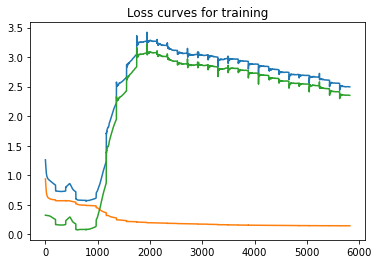

In [6]:
#Create the encoder and decoder components of VQ-VAE Model
encoder = encoder_network()
decoder = decoder_network()
quantizer_layer = Vector_Quantizer()
optimizer = tf.keras.optimizers.Adam(1e-4)

vq_vae_overall = create_overall_vqvae(encoder, quantizer_layer, decoder)

# Training
def train(encoder_net, decoder_net, quantizer_net, opt, vq_model):
    recon_loss_list = []
    latent_loss_list = []

    losses = []
    for epoch in range(1, epochs+1):
        print(epoch)
        loss = -1
        batch_losses = 0

        batch_losses_recon = 0
        batch_losses_latent = 0

        count = 0

        for image_batch in training_ds:

            recon_loss, latent_loss_results, total_loss = training_step(image_batch, opt, encoder_net, quantizer_net, decoder_net, vq_model)

            batch_losses += total_loss
            batch_losses_recon += recon_loss
            batch_losses_latent += latent_loss_results
            count += 1 

            losses.append(batch_losses/count)
            recon_loss_list.append(batch_losses_recon/count)
            latent_loss_list.append(batch_losses_latent/count)
    
    
    # Plot the loss curves
    plt.title('Loss curves for training')
    plt.plot(losses)
    plt.plot(recon_loss_list)
    plt.plot(latent_loss_list)

    plt.show()
    
    #return encoder, decoder, quantizer_layer, vq_vae_overall

train(encoder, decoder, quantizer_layer, optimizer, vq_vae_overall)

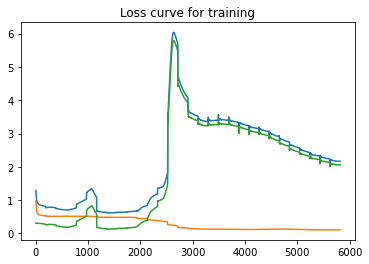

In [158]:
plt.title('Loss curve for training')
plt.plot(losses)
plt.plot(recon_loss_list)
plt.plot(latent_loss_list)

plt.show()

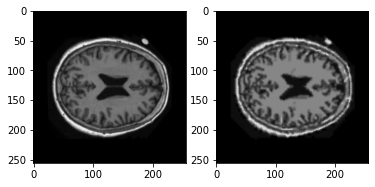

[0.9006816]


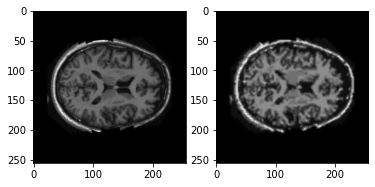

[0.8861061]


In [159]:
test_batch = testing_ds_batched.take(1)
train_batch = training_ds.take(1)
test_image = 0
train_image = 0
for element in test_batch:
    for image in element:
        test_image = image[tf.newaxis, :]
        break
    break

for element in train_batch:
    for image in element:
        train_image = image[tf.newaxis, :]
        break
    break

z = encoder(test_image, training=False)
#Get the quantized latent space
z_quantized, z1 = quantizer_layer(z, training=False)
#Get the reconstructions
result = decoder(z_quantized, training=False)


#Plot the resulting image compared to original
plt.subplot(1,2,1)
plt.imshow(test_image[0, :, :, 0], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(result[0, :, :, 0], cmap='gray')
plt.show()

ssim = tf.image.ssim(test_image, result, max_val = 1)
print(ssim.numpy())


#Check a reconstruction of a training image
z = encoder(train_image, training=False)
#Get the quantized latent space
z_quantized, z1 = quantizer_layer(z, training=False)
#Get the reconstructions
result = decoder(z_quantized, training=False)

#Plot the resulting image compared to original
plt.subplot(1,2,1)
plt.imshow(train_image[0, :, :, 0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(result[0, :, :, 0], cmap='gray')
plt.show()


ssim = tf.image.ssim(train_image, result, max_val = 1)
print(ssim.numpy())


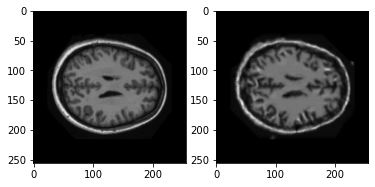

[0.8867183]


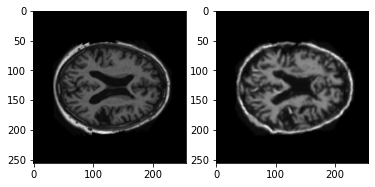

[0.86498463]


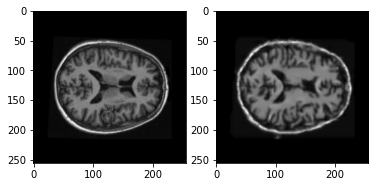

[0.86084414]


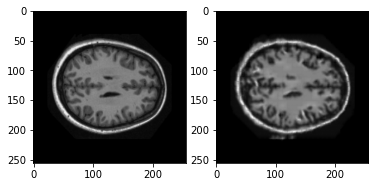

[0.8853166]


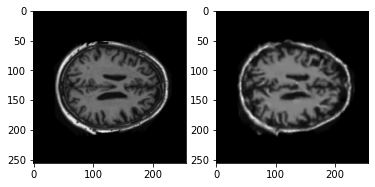

[0.8727031]


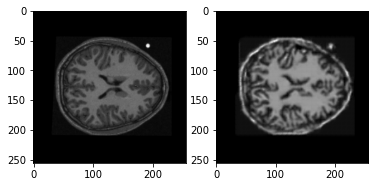

[0.8587636]
Average SSIM score over the testing dataset:  0.8544786


In [7]:
# Calculate SSIM for the entire testing dataset
def calculate_ssims(vq_vae_model_overall):
    ssim_scores_testing = []

    for batch in testing_ds_batched:
        for n,image in enumerate(batch):
            test_image = image[tf.newaxis, :]

            result = vq_vae_model_overall(test_image, training=False)

            #z = encoder(test_image, training=False)
            #Get the quantized latent space
            #z_quantized, z1 = quantizer_layer(z, training=False)
            #Get the reconstructions
            #result = decoder(z_quantized, training=False)

            ssim = tf.image.ssim(test_image, result, max_val = 1)
            ssim_scores_testing.append(ssim)

            # Show an example every 100th image
            if n % 100 == 0:
                #Plot the resulting image compared to original
                plt.subplot(1,2,1)
                plt.imshow(test_image[0, :, :, 0], cmap='gray')

                plt.subplot(1,2,2)
                plt.imshow(result[0, :, :, 0], cmap='gray')
                plt.show()
                print(ssim.numpy())

    #Display the mean ssim
    ssim_score = (tf.reduce_mean(ssim_scores_testing)).numpy()
    return ssim_score

ssim_score = calculate_ssims(vq_vae_overall)
print("Average SSIM score over the testing dataset: ", ssim_score)


In [53]:
# PixelCNN
num_residual_blocks = 2
num_pixelcnn_layers = 2

pixelcnn_input_shape = (32,32)


# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(tf.keras.layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = tf.keras.layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = tf.keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return tf.keras.layers.add([inputs, x])


def create_pixelCNN():
    pixelcnn_inputs = tf.keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
    one_hot_encoding = tf.one_hot(pixelcnn_inputs, K)
    x = PixelConvLayer(
        mask_type="A", filters=128, kernel_size=5, activation="relu", padding="same" #kernel_size = 7!
    )(one_hot_encoding)

    for _ in range(num_residual_blocks):
        x = ResidualBlock(filters=128)(x)

    for _ in range(num_pixelcnn_layers):
        x = PixelConvLayer(
            mask_type="B",
            filters=128,
            kernel_size=1,
            strides=1,
            activation="relu",
            padding="valid",
        )(x)

    out = tf.keras.layers.Conv2D(
        filters=K, kernel_size=1, strides=1, padding="valid"
    )(x)

    pixel_cnn = tf.keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
    return pixel_cnn

pixel_cnn = create_pixelCNN()
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32)]          0         
_________________________________________________________________
tf.one_hot_1 (TFOpLambda)    (None, 32, 32, 512)       0         
_________________________________________________________________
pixel_conv_layer_5 (PixelCon (None, 32, 32, 128)       1638528   
_________________________________________________________________
residual_block_2 (ResidualBl (None, 32, 32, 128)       98624     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 32, 32, 128)       98624     
_________________________________________________________________
pixel_conv_layer_8 (PixelCon (None, 32, 32, 128)       16512     
_________________________________________________________________
pixel_conv_layer_9 (PixelCon (None, 32, 32, 128)       16

Shape of the training data for PixelCNN: (9664, 32, 32)
Epoch 1/500
68/68 [==============================] - 8s 107ms/step - loss: 0.9559 - accuracy: 0.7197 - val_loss: 0.9385 - val_accuracy: 0.7238


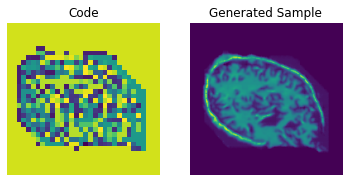

Epoch 2/500
68/68 [==============================] - 7s 103ms/step - loss: 0.9213 - accuracy: 0.7275 - val_loss: 0.9377 - val_accuracy: 0.7241


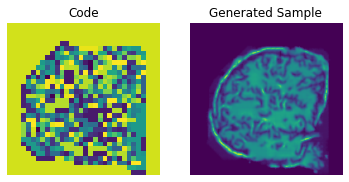

Epoch 3/500
68/68 [==============================] - 7s 103ms/step - loss: 0.9209 - accuracy: 0.7276 - val_loss: 0.9374 - val_accuracy: 0.7240


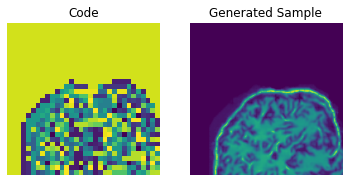

Epoch 4/500
68/68 [==============================] - 7s 103ms/step - loss: 0.9209 - accuracy: 0.7276 - val_loss: 0.9371 - val_accuracy: 0.7241


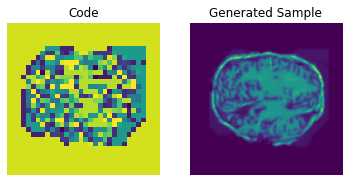

Epoch 5/500
68/68 [==============================] - 7s 103ms/step - loss: 0.9209 - accuracy: 0.7276 - val_loss: 0.9369 - val_accuracy: 0.7241


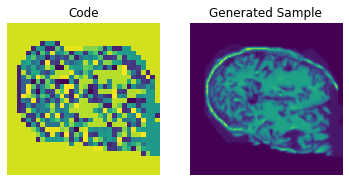

Epoch 6/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9210 - accuracy: 0.7276 - val_loss: 0.9371 - val_accuracy: 0.7240


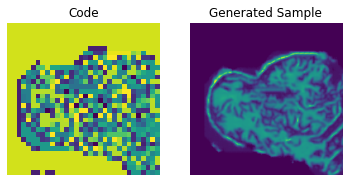

Epoch 7/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9209 - accuracy: 0.7276 - val_loss: 0.9364 - val_accuracy: 0.7243


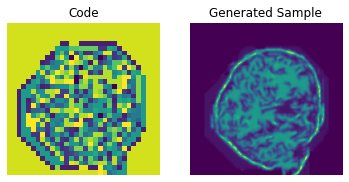

Epoch 8/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9209 - accuracy: 0.7276 - val_loss: 0.9361 - val_accuracy: 0.7242


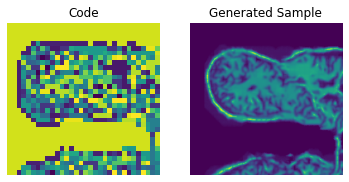

Epoch 9/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9208 - accuracy: 0.7275 - val_loss: 0.9358 - val_accuracy: 0.7243


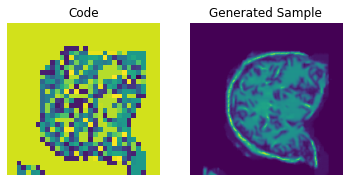

Epoch 10/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9211 - accuracy: 0.7275 - val_loss: 0.9362 - val_accuracy: 0.7244


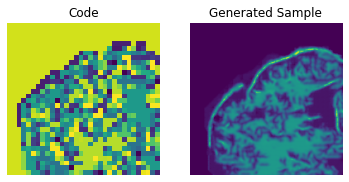

Epoch 11/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9213 - accuracy: 0.7275 - val_loss: 0.9362 - val_accuracy: 0.7241


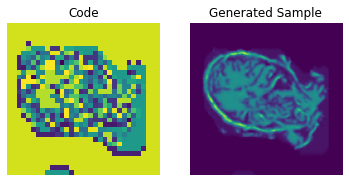

Epoch 12/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9207 - accuracy: 0.7276 - val_loss: 0.9352 - val_accuracy: 0.7245


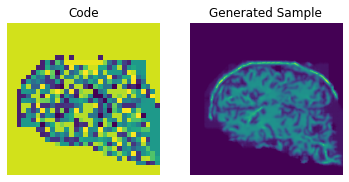

Epoch 13/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9206 - accuracy: 0.7276 - val_loss: 0.9352 - val_accuracy: 0.7242


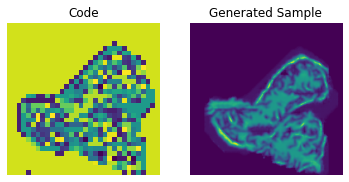

Epoch 14/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9203 - accuracy: 0.7277 - val_loss: 0.9350 - val_accuracy: 0.7244


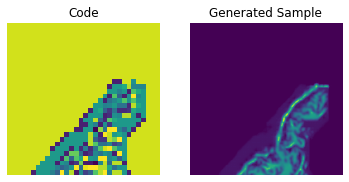

Epoch 15/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9204 - accuracy: 0.7276 - val_loss: 0.9341 - val_accuracy: 0.7247


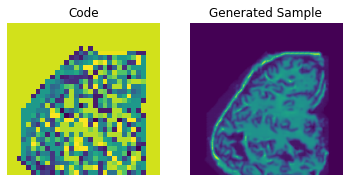

Epoch 16/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9202 - accuracy: 0.7277 - val_loss: 0.9348 - val_accuracy: 0.7245


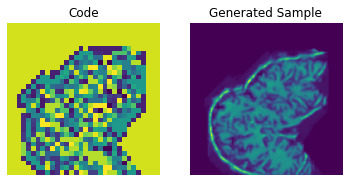

Epoch 17/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9202 - accuracy: 0.7277 - val_loss: 0.9343 - val_accuracy: 0.7248


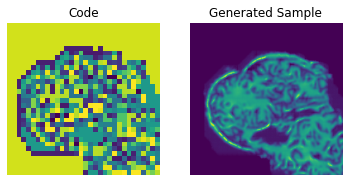

Epoch 18/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9204 - accuracy: 0.7276 - val_loss: 0.9340 - val_accuracy: 0.7248


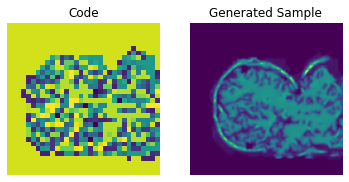

Epoch 19/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9201 - accuracy: 0.7277 - val_loss: 0.9340 - val_accuracy: 0.7245


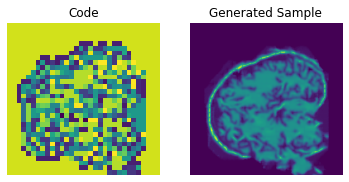

Epoch 20/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9200 - accuracy: 0.7277 - val_loss: 0.9348 - val_accuracy: 0.7245


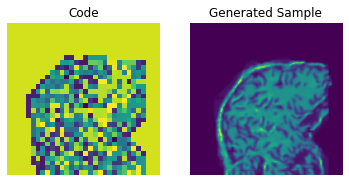

Epoch 21/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9196 - accuracy: 0.7278 - val_loss: 0.9334 - val_accuracy: 0.7250


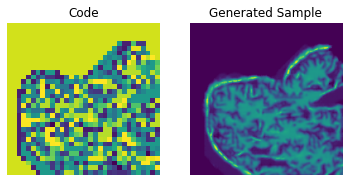

Epoch 22/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9196 - accuracy: 0.7278 - val_loss: 0.9332 - val_accuracy: 0.7248


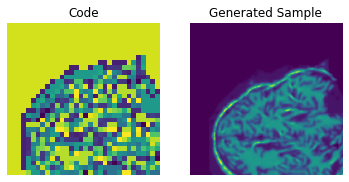

Epoch 23/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9195 - accuracy: 0.7279 - val_loss: 0.9330 - val_accuracy: 0.7249


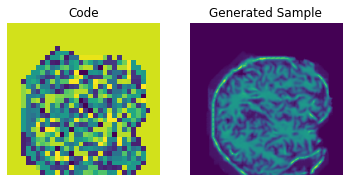

Epoch 24/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9200 - accuracy: 0.7278 - val_loss: 0.9326 - val_accuracy: 0.7249


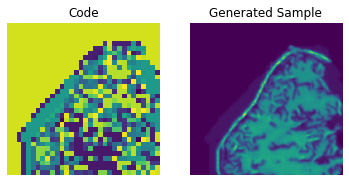

Epoch 25/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9195 - accuracy: 0.7278 - val_loss: 0.9350 - val_accuracy: 0.7245


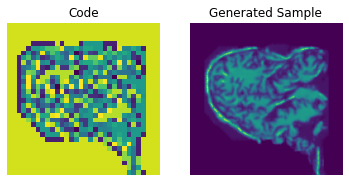

Epoch 26/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9190 - accuracy: 0.7279 - val_loss: 0.9325 - val_accuracy: 0.7250


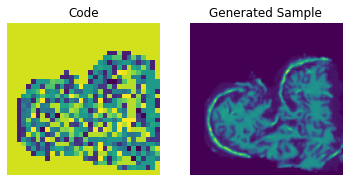

Epoch 27/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9191 - accuracy: 0.7280 - val_loss: 0.9319 - val_accuracy: 0.7252


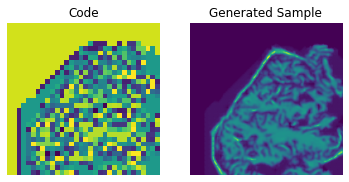

Epoch 28/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9191 - accuracy: 0.7279 - val_loss: 0.9321 - val_accuracy: 0.7251


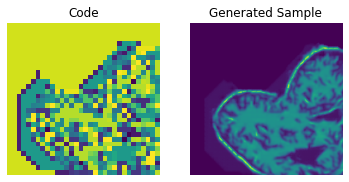

Epoch 29/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9187 - accuracy: 0.7280 - val_loss: 0.9317 - val_accuracy: 0.7251


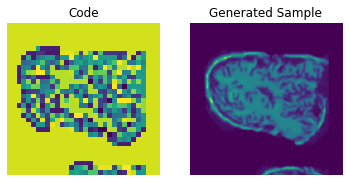

Epoch 30/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9188 - accuracy: 0.7280 - val_loss: 0.9317 - val_accuracy: 0.7251


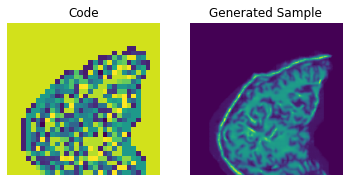

Epoch 31/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9186 - accuracy: 0.7280 - val_loss: 0.9328 - val_accuracy: 0.7251


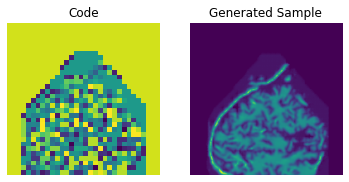

Epoch 32/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9185 - accuracy: 0.7280 - val_loss: 0.9316 - val_accuracy: 0.7253


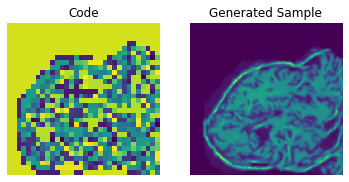

Epoch 33/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9184 - accuracy: 0.7280 - val_loss: 0.9310 - val_accuracy: 0.7254


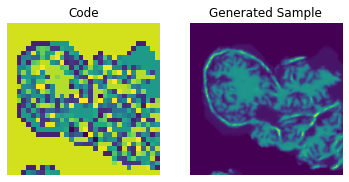

Epoch 34/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9184 - accuracy: 0.7281 - val_loss: 0.9305 - val_accuracy: 0.7256


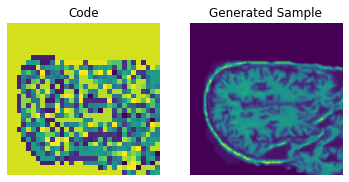

Epoch 35/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9176 - accuracy: 0.7283 - val_loss: 0.9323 - val_accuracy: 0.7249


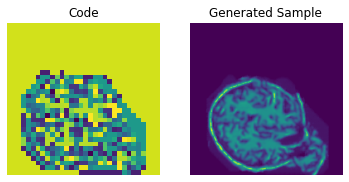

Epoch 36/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9180 - accuracy: 0.7281 - val_loss: 0.9300 - val_accuracy: 0.7257


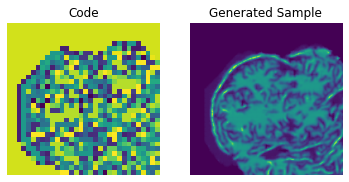

Epoch 37/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9175 - accuracy: 0.7283 - val_loss: 0.9302 - val_accuracy: 0.7257


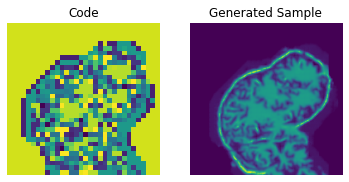

Epoch 38/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9172 - accuracy: 0.7283 - val_loss: 0.9302 - val_accuracy: 0.7257


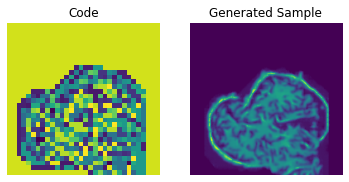

Epoch 39/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9178 - accuracy: 0.7282 - val_loss: 0.9308 - val_accuracy: 0.7253


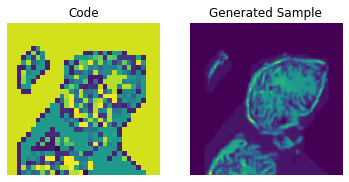

Epoch 40/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9174 - accuracy: 0.7283 - val_loss: 0.9302 - val_accuracy: 0.7253


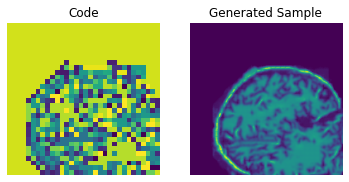

Epoch 41/500
68/68 [==============================] - 7s 105ms/step - loss: 0.9173 - accuracy: 0.7283 - val_loss: 0.9341 - val_accuracy: 0.7246


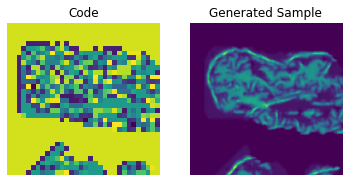

Epoch 42/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9171 - accuracy: 0.7283 - val_loss: 0.9299 - val_accuracy: 0.7256


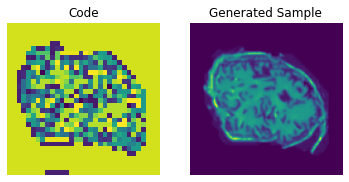

Epoch 43/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9173 - accuracy: 0.7283 - val_loss: 0.9293 - val_accuracy: 0.7257


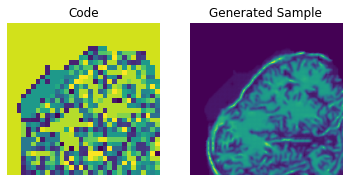

Epoch 44/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9165 - accuracy: 0.7285 - val_loss: 0.9294 - val_accuracy: 0.7258


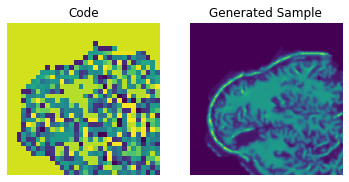

Epoch 45/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9164 - accuracy: 0.7286 - val_loss: 0.9295 - val_accuracy: 0.7257


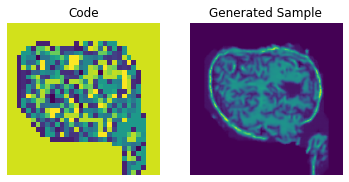

Epoch 46/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9164 - accuracy: 0.7285 - val_loss: 0.9290 - val_accuracy: 0.7258


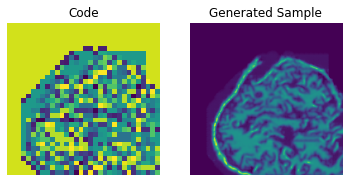

Epoch 47/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9169 - accuracy: 0.7284 - val_loss: 0.9306 - val_accuracy: 0.7255


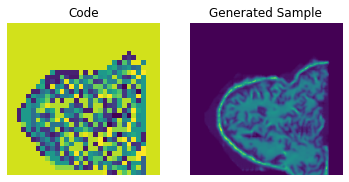

Epoch 48/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9165 - accuracy: 0.7284 - val_loss: 0.9287 - val_accuracy: 0.7258


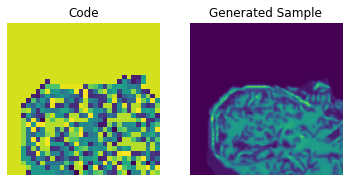

Epoch 49/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9162 - accuracy: 0.7286 - val_loss: 0.9286 - val_accuracy: 0.7260


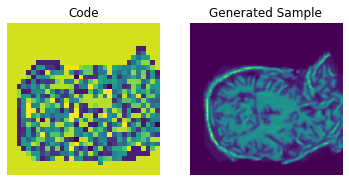

Epoch 50/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9156 - accuracy: 0.7288 - val_loss: 0.9295 - val_accuracy: 0.7257


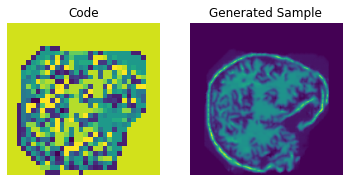

Epoch 51/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9157 - accuracy: 0.7287 - val_loss: 0.9282 - val_accuracy: 0.7259


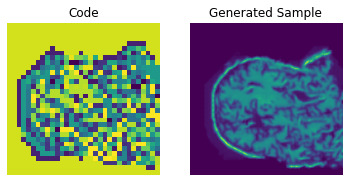

Epoch 52/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9159 - accuracy: 0.7287 - val_loss: 0.9289 - val_accuracy: 0.7258


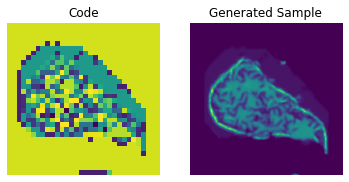

Epoch 53/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9159 - accuracy: 0.7286 - val_loss: 0.9285 - val_accuracy: 0.7260


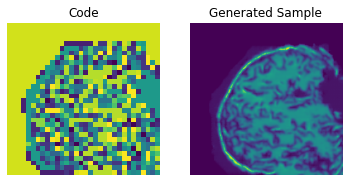

Epoch 54/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9156 - accuracy: 0.7287 - val_loss: 0.9322 - val_accuracy: 0.7250


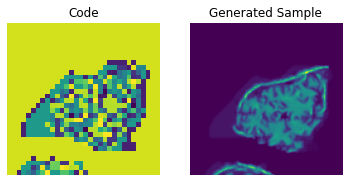

Epoch 55/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9155 - accuracy: 0.7288 - val_loss: 0.9274 - val_accuracy: 0.7261


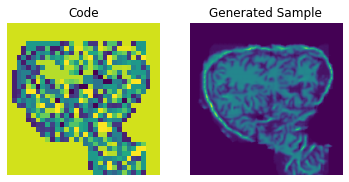

Epoch 56/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9154 - accuracy: 0.7287 - val_loss: 0.9276 - val_accuracy: 0.7261


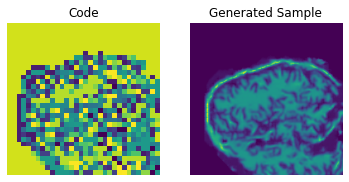

Epoch 57/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9151 - accuracy: 0.7288 - val_loss: 0.9271 - val_accuracy: 0.7262


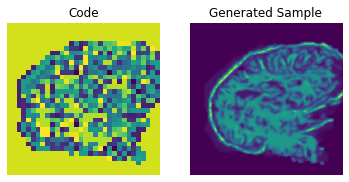

Epoch 58/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9153 - accuracy: 0.7288 - val_loss: 0.9278 - val_accuracy: 0.7261


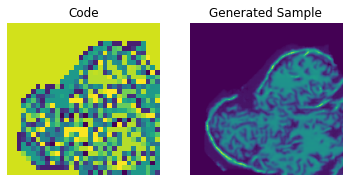

Epoch 59/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9149 - accuracy: 0.7289 - val_loss: 0.9272 - val_accuracy: 0.7263


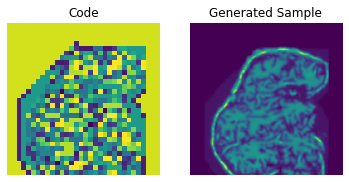

Epoch 60/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9150 - accuracy: 0.7288 - val_loss: 0.9285 - val_accuracy: 0.7260


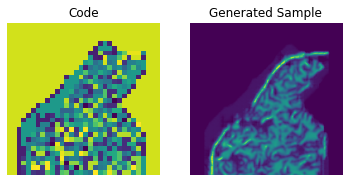

Epoch 61/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9146 - accuracy: 0.7289 - val_loss: 0.9267 - val_accuracy: 0.7263


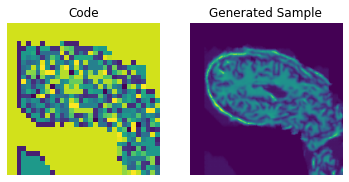

Epoch 62/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9147 - accuracy: 0.7289 - val_loss: 0.9285 - val_accuracy: 0.7260


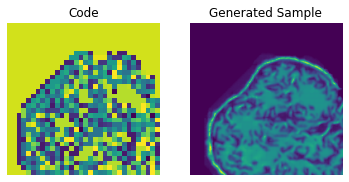

Epoch 63/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9150 - accuracy: 0.7288 - val_loss: 0.9264 - val_accuracy: 0.7263


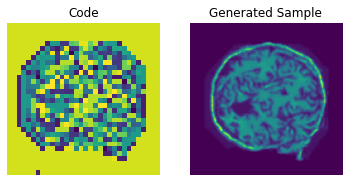

Epoch 64/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9144 - accuracy: 0.7290 - val_loss: 0.9264 - val_accuracy: 0.7265


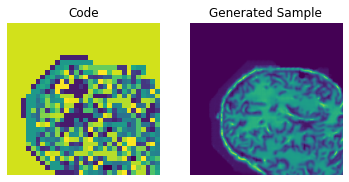

Epoch 65/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9143 - accuracy: 0.7289 - val_loss: 0.9262 - val_accuracy: 0.7265


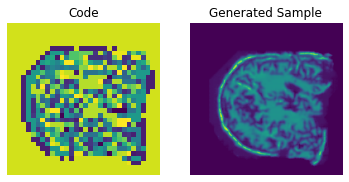

Epoch 66/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9139 - accuracy: 0.7291 - val_loss: 0.9263 - val_accuracy: 0.7263


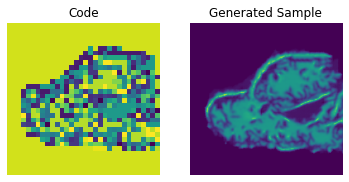

Epoch 67/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9142 - accuracy: 0.7290 - val_loss: 0.9267 - val_accuracy: 0.7262


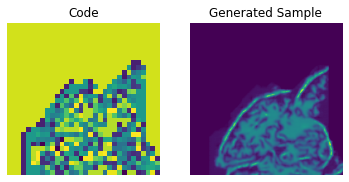

Epoch 68/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9138 - accuracy: 0.7291 - val_loss: 0.9257 - val_accuracy: 0.7266


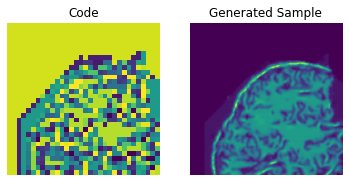

Epoch 69/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9134 - accuracy: 0.7292 - val_loss: 0.9257 - val_accuracy: 0.7265


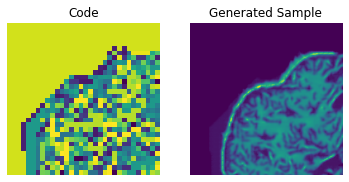

Epoch 70/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9143 - accuracy: 0.7289 - val_loss: 0.9255 - val_accuracy: 0.7266


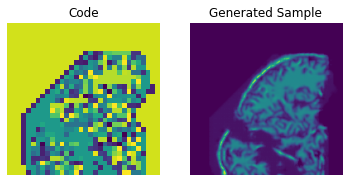

Epoch 71/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9139 - accuracy: 0.7290 - val_loss: 0.9258 - val_accuracy: 0.7264


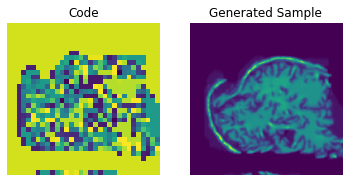

Epoch 72/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9131 - accuracy: 0.7292 - val_loss: 0.9255 - val_accuracy: 0.7266


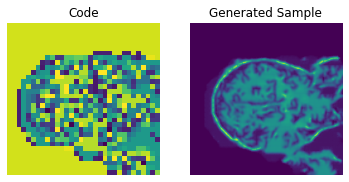

Epoch 73/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9132 - accuracy: 0.7292 - val_loss: 0.9260 - val_accuracy: 0.7266


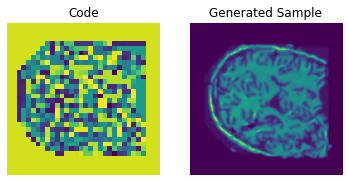

Epoch 74/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9133 - accuracy: 0.7292 - val_loss: 0.9252 - val_accuracy: 0.7268


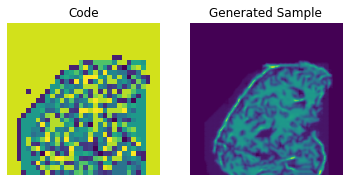

Epoch 75/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9129 - accuracy: 0.7293 - val_loss: 0.9257 - val_accuracy: 0.7266


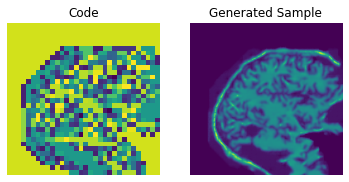

Epoch 76/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9132 - accuracy: 0.7292 - val_loss: 0.9254 - val_accuracy: 0.7267


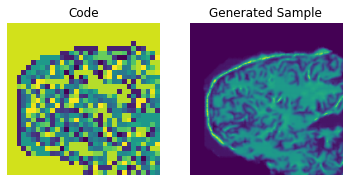

Epoch 77/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9130 - accuracy: 0.7292 - val_loss: 0.9256 - val_accuracy: 0.7266


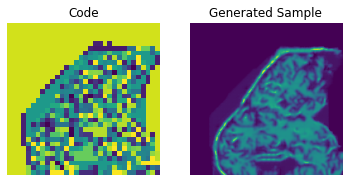

Epoch 78/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9126 - accuracy: 0.7293 - val_loss: 0.9255 - val_accuracy: 0.7266


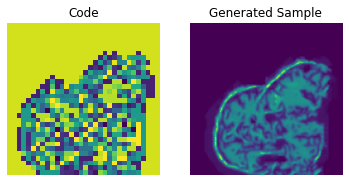

Epoch 79/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9127 - accuracy: 0.7293 - val_loss: 0.9246 - val_accuracy: 0.7267


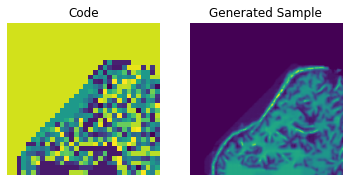

Epoch 80/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9126 - accuracy: 0.7293 - val_loss: 0.9262 - val_accuracy: 0.7266


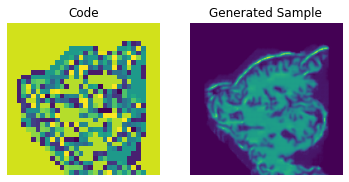

Epoch 81/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9123 - accuracy: 0.7294 - val_loss: 0.9240 - val_accuracy: 0.7269


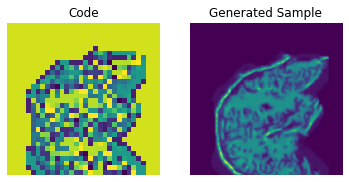

Epoch 82/500
68/68 [==============================] - 7s 104ms/step - loss: 0.9122 - accuracy: 0.7294 - val_loss: 0.9245 - val_accuracy: 0.7268


In [ ]:
#PixelCNN Training

codebook_indices_vector = []

def get_codebook_indices(codebook_indices_vector):
    for n,batch in enumerate(training_ds):
        # Generate the codebook indices.
        encoded_outputs = encoder.predict(batch)
        flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
        codebook_indices, vectors = quantizer_layer.quantize_vectors(flat_enc_outputs)

        codebook_indices2 = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

        if n == 0:
            codebook_indices_vector = codebook_indices2
        else:
            codebook_indices_vector = tf.concat([codebook_indices_vector, codebook_indices2], 0)
        #print(codebook_indices_vector.shape)
    
    return codebook_indices_vector
    
codebook_indices_vector = get_codebook_indices(codebook_indices_vector)
print(f"Shape of the training data for PixelCNN: {codebook_indices_vector.shape}")

pixel_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices_vector,
    y=codebook_indices_vector,
    batch_size=128,
    epochs=500,
    validation_split=0.1,
    callbacks=[CustomCallback()]
)

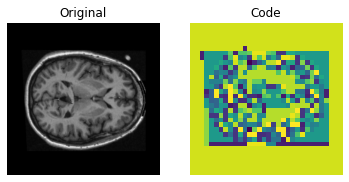

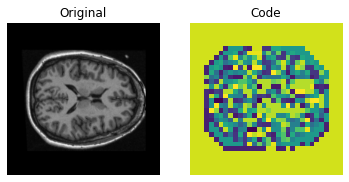

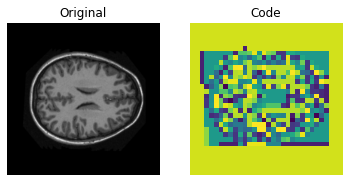

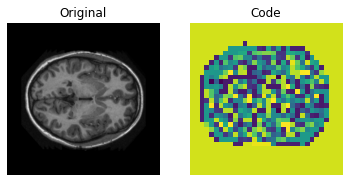

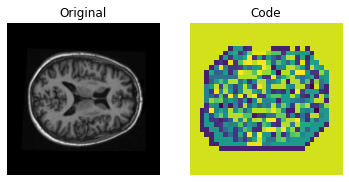

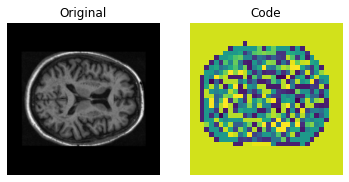

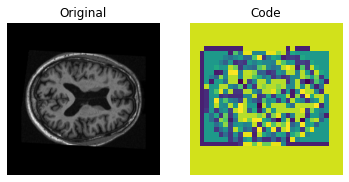

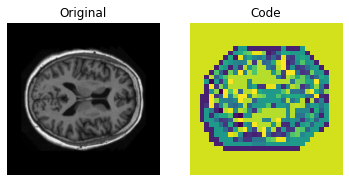

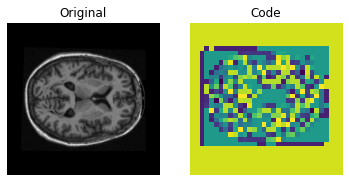

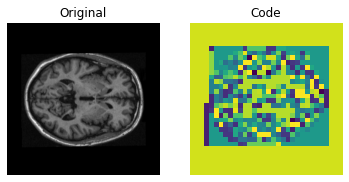

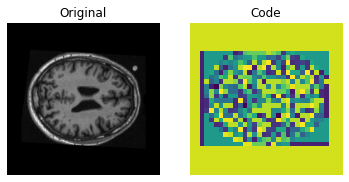

In [50]:
encoded_outputs = encoder.predict(testing_ds_unbatched)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices, vectors = quantizer_layer.quantize_vectors(flat_enc_outputs)
codebook_indices2 = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i, image in enumerate(testing_ds_unbatched):
    plt.subplot(1, 2, 1)
    plt.imshow(image[0, :, :, 0], cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices2[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()
    
    if i > 10:
        break

In [58]:
##ATTEMPT 3
batch = 30
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.        
        x = pixel_cnn(priors, training=False)
        dist = tfp.distributions.Categorical(logits=x)
        sampled = dist.sample()
        
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = sampled[:, row, col]

print(f"Prior shape: {priors.shape}")


Prior shape: (30, 32, 32)


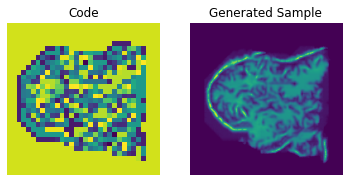

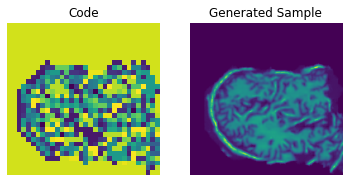

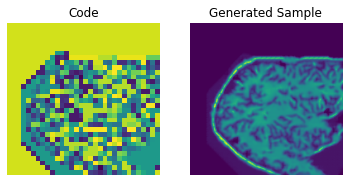

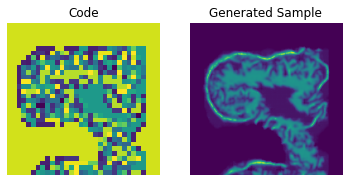

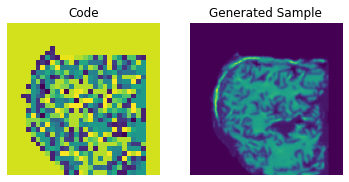

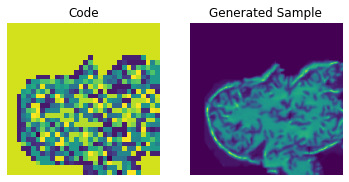

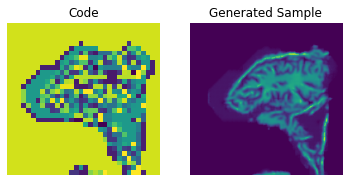

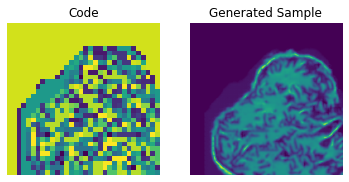

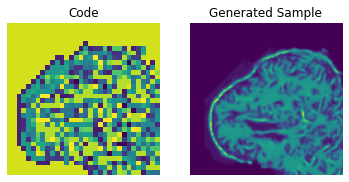

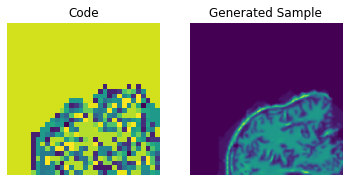

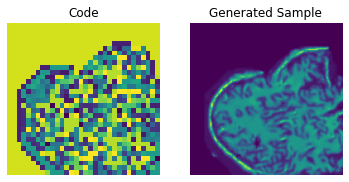

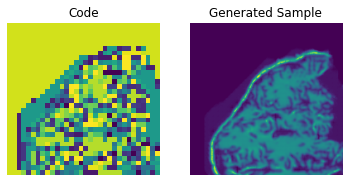

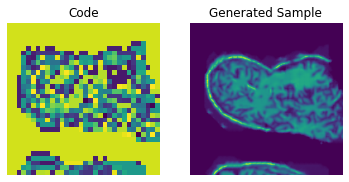

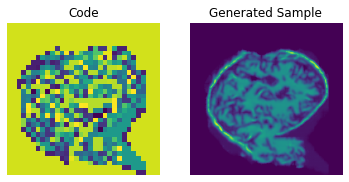

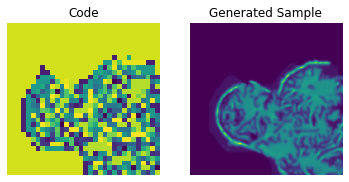

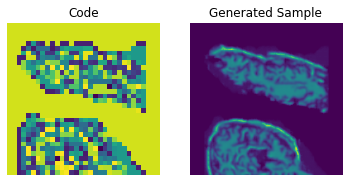

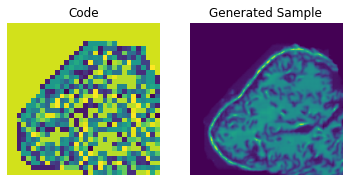

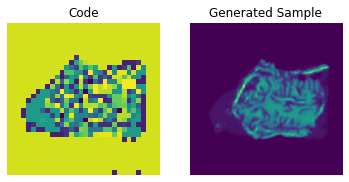

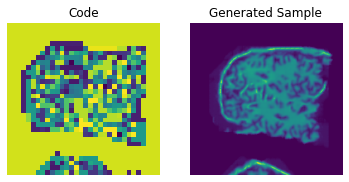

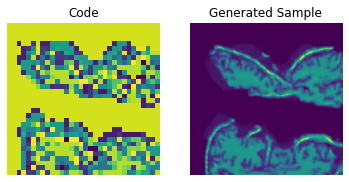

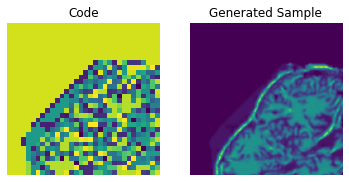

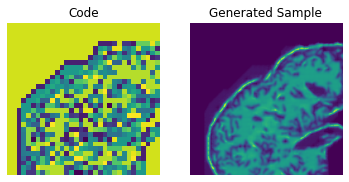

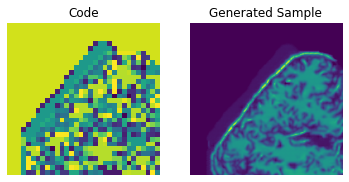

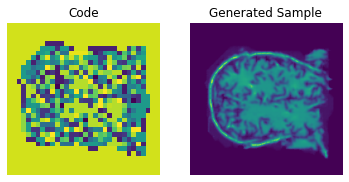

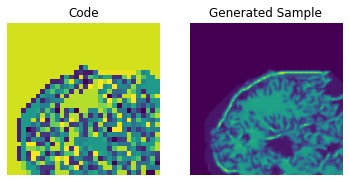

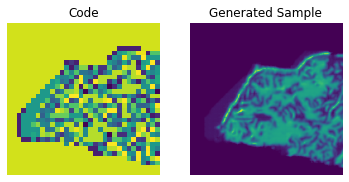

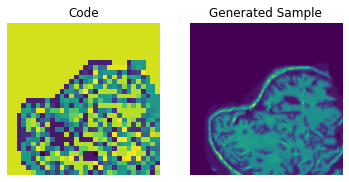

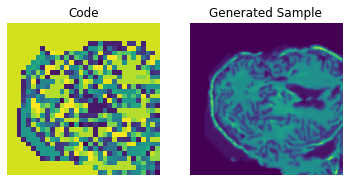

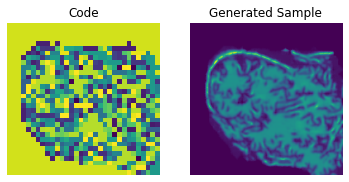

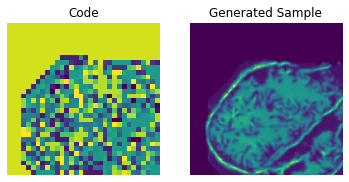

In [59]:
# ATTEMPT 3 Perform an embedding lookup.
pretrained_embeddings = quantizer_layer._embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), K).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

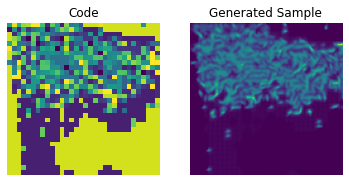

In [35]:
###ATTEMPT 2
priors = samples
encoded_outputs = []
# Perform an embedding lookup.
for n,batch in enumerate(training_ds):
    # Get the encoded shape
    encoded_outputs = encoder.predict(batch)
    break

pretrained_embeddings = quantizer_layer._embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), K).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *((encoded_outputs.shape[1:]))))

# Generate novel images.
generated_samples = decoder.predict(quantized)

for i in range(1):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

In [62]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        batch = 1
        priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
        batch, rows, cols = priors.shape

        # Iterate over the priors because generation has to be done sequentially pixel by pixel.
        for row in range(rows):
            for col in range(cols):
                # Feed the whole array and retrieving the pixel value probabilities for the next
                # pixel.        
                x = pixel_cnn(priors, training=False)
                dist = tfp.distributions.Categorical(logits=x)
                sampled = dist.sample()

                # Use the probabilities to pick pixel values and append the values to the priors.
                priors[:, row, col] = sampled[:, row, col]
        
        #Perform an embedding lookup.
        pretrained_embeddings = quantizer_layer._embeddings
        priors_ohe = tf.one_hot(priors.astype("int32"), K).numpy()
        quantized = tf.matmul(
            priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
        )
        quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

        # Generate novel images.
        generated_samples = decoder.predict(quantized)

        for i in range(batch):
            plt.subplot(1, 2, 1)
            plt.imshow(priors[i])
            # save a image using extension
            plt.imsave('prior_epoch{}.png'.format(epoch), priors[i])
            plt.title("Code")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(generated_samples[i])
            plt.imsave('generated_epoch{}.png'.format(epoch), priors[i])
            plt.title("Generated Sample")
            plt.axis("off")
            plt.show()
